In [2]:
%load_ext autoreload
%autoreload 2
import os 
os.chdir("/Users/luohy/Documents/Projects/bus-observatory/gtfs-realtime-performance")
from src.s3 import list_files_in_bucket, filter_files_by_pattern, read_parquet_from_s3
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed
from src.gtfs_segments import GTFS_shape_processor
from src.speeds import BusSpeedCalculator
from src.api import parse_zipped_gtfs
import geopandas as gpd
from src.api import query_feed_data, get_access_token
ACCESS_TOKEN = get_access_token()
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
from collections import defaultdict
from shapely.geometry import Point, Polygon
from datetime import datetime
import pytz


# Preparation 

In [3]:
prefix = "norm/bus-mta-vp/vehicles/"
bucket = "dataclinic-gtfs-rt"

In [4]:
def load_all_parquet_files(file_list, bucket, max_workers=100):
    dfs = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(read_parquet_from_s3, bucket, key) for key in file_list]
        for future in as_completed(futures):
            try:
                dfs.append(future.result())
            except Exception as e:
                print(f"Error reading a file: {e}")
    print(f"Read {len(dfs)} files from s3")
    return pd.concat(dfs, ignore_index=True)

In [5]:
def load_all_csv_files(file_list, dir):
    # return a concatenated dataframe
    dfs = []
    for file in file_list:
        dfs.append(pd.read_csv(os.path.join(dir, file)))
    return pd.concat(dfs, ignore_index=True)

In [6]:
def get_all_weekdays(start_date: str, end_date: str, weekday_type: int):
    # 0 - Monday, 1 - Tuesday, ..., 6 - Sunday
    # return a list of date strings
    dates = []
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    for date in date_range:
        if date.weekday() == weekday_type:
            dates.append(date.strftime('%Y-%m-%d'))
    return dates

ans = get_all_weekdays("2025-01-01", "2025-01-31", 0) # get all mondays
print(ans)

['2025-01-06', '2025-01-13', '2025-01-20', '2025-01-27']


## Step 0: Figure out which static feed is correct.

Pretty annoying. The trips and shapes are defined in the static gtfs feeds, and everytime a new static feed is released, the old `trip_id` values become obsolete. This is unfortunate because . It should be possible to just load all of the relevant static feeds and run a quick check on the relevant realtime feed data to see which static feed is in correct for the given dates. However, we can also just look through the outputs from MobilityData's API and find the one we want. Below, I load all the feeds for Manhattan.

In [7]:
response = query_feed_data("mdb-513", ACCESS_TOKEN)
# https://mobilitydatabase.org/feeds/mdb-513

response

[{'id': 'mdb-513-202402080022',
  'feed_id': 'mdb-513',
  'hosted_url': 'https://files.mobilitydatabase.org/mdb-513/mdb-513-202402080022/mdb-513-202402080022.zip',
  'note': None,
  'downloaded_at': '2024-02-08T00:52:25.481924Z',
  'hash': '25ebc713eff01d5d5da7e6a877926d636152417153dc591ef0763fa0851b3819',
  'bounding_box': {'minimum_latitude': 40.701536,
   'maximum_latitude': 40.865316,
   'minimum_longitude': -74.018088,
   'maximum_longitude': -73.864375},
  'validation_report': None,
  'service_date_range_start': None,
  'service_date_range_end': None},
 {'id': 'mdb-513-202404010033',
  'feed_id': 'mdb-513',
  'hosted_url': 'https://files.mobilitydatabase.org/mdb-513/mdb-513-202404010033/mdb-513-202404010033.zip',
  'note': None,
  'downloaded_at': '2024-04-01T00:26:36.207481Z',
  'hash': '4e9fce8767c4fe3eb5f0529ea49d29270543d0563d7fbf0d8c4c0920b61a3fbf',
  'bounding_box': {'minimum_latitude': 40.701536,
   'maximum_latitude': 40.865316,
   'minimum_longitude': -74.018088,
   'max

In [8]:
def fetch_all_static_feeds(mdb_id, ACCESS_TOKEN) -> pd.DataFrame:
    response = query_feed_data(mdb_id, ACCESS_TOKEN)
    if response is None:
        raise ValueError("No response for mdb_id: ", mdb_id)
    feed_updates = pd.DataFrame(response)
    if feed_updates["service_date_range_start"].isnull().all(): # Include start date
        feed_updates["service_date_range_start"] = feed_updates["downloaded_at"].str.extract(r"(\d{4}-\d{2}-\d{2})")
    if feed_updates["service_date_range_end"].isnull().all(): # Exclude end date
        next_row_dates = feed_updates["downloaded_at"].shift(-1).str.extract(r"(\d{4}-\d{2}-\d{2})")
        feed_updates["service_date_range_end"] = next_row_dates
    return feed_updates

mdb_id = "mdb-513"
feed_updates = fetch_all_static_feeds(mdb_id, ACCESS_TOKEN=ACCESS_TOKEN)
print(feed_updates)


                     id  feed_id  \
0  mdb-513-202402080022  mdb-513   
1  mdb-513-202404010033  mdb-513   
2  mdb-513-202407010038  mdb-513   
3  mdb-513-202408290052  mdb-513   
4  mdb-513-202409090026  mdb-513   
5  mdb-513-202412120015  mdb-513   
6  mdb-513-202501020055  mdb-513   
7  mdb-513-202501230024  mdb-513   
8  mdb-513-202502170105  mdb-513   

                                          hosted_url  note  \
0  https://files.mobilitydatabase.org/mdb-513/mdb...  None   
1  https://files.mobilitydatabase.org/mdb-513/mdb...  None   
2  https://files.mobilitydatabase.org/mdb-513/mdb...  None   
3  https://files.mobilitydatabase.org/mdb-513/mdb...  None   
4  https://files.mobilitydatabase.org/mdb-513/mdb...  None   
5  https://files.mobilitydatabase.org/mdb-513/mdb...  None   
6  https://files.mobilitydatabase.org/mdb-513/mdb...  None   
7  https://files.mobilitydatabase.org/mdb-513/mdb...  None   
8  https://files.mobilitydatabase.org/mdb-513/mdb...  None   

                 d

In [9]:
# Get correct url for a given date
def get_correct_static_url(feed_updates, date):
    candidates = feed_updates[feed_updates["service_date_range_start"] <= date < feed_updates["service_date_range_end"]]
    if candidates.empty:
        print(f"No static feed found before {date}")
        return None
    else:
        # return the last row which should be the latest static feed
        return candidates.iloc[-1]["hosted_url"], candidates.iloc[-1]["id"]

# Use Case 1: Bus Speed Comparsion

- Bus Route: M50
- Date: Dec 2024 and Jan 2025, Thursday only？ 
- Time: median speed for each hour / half hour
- Plot: Line graph for each date 


In [10]:
bucket = "dataclinic-gtfs-rt"

def calculate_speeds_for_route(bucket, date, route_id):
    # Step 0: Get the correct static feed and specify the url based on the date given
    correct_url, _ = get_correct_static_url(feed_updates, date)

    # Step 1: Process static feed shapes into geodataframe
    # this takes 2.5 seconds, which can be improved 
    segment_df = GTFS_shape_processor(correct_url, 4326, 2263).process_shapes()

    # Step 2: Load relevant realtime data from s3 bucket for the given date
    daily_files = list_files_in_bucket(bucket_name = bucket, prefix = f"{prefix}date={date}/")
    vehicle_positions = load_all_parquet_files(file_list = daily_files, bucket = bucket)
    GTFS_dict = parse_zipped_gtfs(correct_url)

    # Step 3: Calculate speeds
    speed_calculator = BusSpeedCalculator(vehicle_positions, GTFS_dict, segment_df)
    speeds = speed_calculator.create_trip_speeds()
    speeds = speed_calculator.match_trip_with_route(speeds)
    
    # remove outlier
    speeds = speeds[speeds["route_id"] == route_id]
    speeds = speeds[speeds["speed_mph"] < 70]
    return speeds

## 1. Data Extraction and Storage (Skipped if it has already been done)

In [16]:
bucket = "dataclinic-gtfs-rt"
route_id = "M50"

weekday_type = 0
experiment_mondays = get_all_weekdays("2025-01-05", "2025-01-31", weekday_type)
comparison_mondays = get_all_weekdays("2024-12-05", "2024-12-31", weekday_type)

print(experiment_mondays)
print(comparison_mondays)

# Create directories if they do not exist
os.makedirs("data/2025-jan/", exist_ok=True)
os.makedirs("data/2024-dec/", exist_ok=True)

# Process experiment mondays
for date in experiment_mondays:
    speeds = calculate_speeds_for_route(bucket, date, route_id)
    speeds.to_csv(os.path.join("data/2025-jan/", f"speeds_{route_id}_{date}.csv"), index=False)
    print(f"Saved speeds for {route_id} on {date}")

# Process comparison mondays
for date in comparison_mondays:
    speeds = calculate_speeds_for_route(bucket, date, route_id)
    speeds.to_csv(os.path.join("data/2024-dec/", f"speeds_{route_id}_{date}.csv"), index=False)
    print(f"Saved speeds for {route_id} on {date}")

['2025-01-06', '2025-01-13', '2025-01-20', '2025-01-27']
['2024-12-09', '2024-12-16', '2024-12-23', '2024-12-30']
Parsed GTFS static feed data successfully


/Users/luohy/Documents/Projects/bus-observatory/gtfs-realtime-performance/.venv/lib/python3.10/site-packages/shapely/linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)


Read 1403 files from s3
Parsed GTFS static feed data successfully
Processing 9755 trips...


100%|██████████| 9755/9755 [02:08<00:00, 76.12it/s] 


Saved speeds for M50 on 2025-01-06
Parsed GTFS static feed data successfully


/Users/luohy/Documents/Projects/bus-observatory/gtfs-realtime-performance/.venv/lib/python3.10/site-packages/shapely/linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)


Read 1402 files from s3
Parsed GTFS static feed data successfully
Processing 9945 trips...


100%|██████████| 9945/9945 [02:09<00:00, 77.05it/s]


Saved speeds for M50 on 2025-01-13
Parsed GTFS static feed data successfully


/Users/luohy/Documents/Projects/bus-observatory/gtfs-realtime-performance/.venv/lib/python3.10/site-packages/shapely/linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)


Read 1404 files from s3
Parsed GTFS static feed data successfully
Processing 8407 trips...


100%|██████████| 8407/8407 [01:37<00:00, 85.80it/s] 


Saved speeds for M50 on 2025-01-20
Parsed GTFS static feed data successfully


/Users/luohy/Documents/Projects/bus-observatory/gtfs-realtime-performance/.venv/lib/python3.10/site-packages/shapely/linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)


Read 1405 files from s3
Parsed GTFS static feed data successfully
Processing 9859 trips...


100%|██████████| 9859/9859 [02:09<00:00, 75.97it/s]


Saved speeds for M50 on 2025-01-27
Parsed GTFS static feed data successfully


/Users/luohy/Documents/Projects/bus-observatory/gtfs-realtime-performance/.venv/lib/python3.10/site-packages/shapely/linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)


Read 1402 files from s3
Parsed GTFS static feed data successfully
Processing 9718 trips...


100%|██████████| 9718/9718 [02:02<00:00, 79.34it/s] 


Saved speeds for M50 on 2024-12-09
Parsed GTFS static feed data successfully


/Users/luohy/Documents/Projects/bus-observatory/gtfs-realtime-performance/.venv/lib/python3.10/site-packages/shapely/linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)


Read 1403 files from s3
Parsed GTFS static feed data successfully
Processing 9390 trips...


100%|██████████| 9390/9390 [01:52<00:00, 83.41it/s] 


Saved speeds for M50 on 2024-12-16
Parsed GTFS static feed data successfully


/Users/luohy/Documents/Projects/bus-observatory/gtfs-realtime-performance/.venv/lib/python3.10/site-packages/shapely/linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)


Read 1403 files from s3
Parsed GTFS static feed data successfully
Processing 9633 trips...


100%|██████████| 9633/9633 [01:59<00:00, 80.51it/s] 


Saved speeds for M50 on 2024-12-23
Parsed GTFS static feed data successfully


/Users/luohy/Documents/Projects/bus-observatory/gtfs-realtime-performance/.venv/lib/python3.10/site-packages/shapely/linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)


Read 1403 files from s3
Parsed GTFS static feed data successfully
Processing 8746 trips...


100%|██████████| 8746/8746 [01:40<00:00, 87.06it/s] 


Saved speeds for M50 on 2024-12-30


## 2. Data Loading and Transformation
TODOs:
- Geographical check
- Timezone check
- Experiment with different aggregation methods
- Experiment with different visualization methods

In [25]:
# loading and concatenting all the files needed
def list_files(folder_path):
    return [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

bus_speed_202412thurs = load_all_csv_files(list_files("data/2024-dec/"), "data/2024-dec/")
bus_speed_202501thurs = load_all_csv_files(list_files("data/2025-jan/"), "data/2025-jan/")

bus_speed_202412thurs.drop('Unnamed: 0', axis=1, inplace=True)
bus_speed_202501thurs.drop('Unnamed: 0', axis=1, inplace=True)

print(bus_speed_202412thurs.columns)
print(bus_speed_202501thurs.columns)

# check the first row of the dataframe
print(bus_speed_202412thurs.iloc[0])


Index(['trip_id', 'shape_id', 'stop_sequence', 'stop_id', 'stop_name',
       'prev_stop_id', 'prev_stop_name', 'projected_position',
       'prev_projected_position', 'segment_length', 'interpolated_time',
       'time_elapsed', 'speed_mph', 'unique_trip_id', 'route_id'],
      dtype='object')
Index(['trip_id', 'shape_id', 'stop_sequence', 'stop_id', 'stop_name',
       'prev_stop_id', 'prev_stop_name', 'projected_position',
       'prev_projected_position', 'segment_length', 'interpolated_time',
       'time_elapsed', 'speed_mph', 'unique_trip_id', 'route_id'],
      dtype='object')
trip_id                                         MQ_O4-Weekday-027800_M50_351
shape_id                                                             M500048
stop_sequence                                                              3
stop_id                                                               402161
stop_name                                                      12 AV/W 46 ST
prev_stop_id           

### Geographical Boundary Check

In [26]:
# load the boundary shape file
boundary = gpd.read_file("data/congestion_zone_boundary.geojson")

# create stop points from feed:  url -> GTFS_dict -> stops.txt
def create_and_check_stop_points(feed_identifier, feed_updates, boundary_shape):
    # get GFTS dict from feed_identifier
    url = feed_updates[feed_updates["id"] == feed_identifier]["hosted_url"].iloc[0]
    GTFS_dict = parse_zipped_gtfs(url)
    # get stops from GTFS_dict
    stops = GTFS_dict["stops.txt"]
    # create stop points geodataframe from stops
    stop_points = gpd.GeoDataFrame(stops, geometry=gpd.points_from_xy(stops.stop_lon, stops.stop_lat))
    # run point in polygon check, and return a new column "in_boundary"
    stop_points["in_boundary"] = stop_points.geometry.apply(lambda x: boundary_shape.contains(x))
    # print(stop_points.columns)
    print("Distribution of stop points in boundary: ")
    print(stop_points["in_boundary"].value_counts())
    return stop_points

In [27]:
# create a dataframe of stops in the boundary
stops_in_boundary = pd.DataFrame()
feed_candidates = ["mdb-513-202412120015", "mdb-513-202501020055", "mdb-513-202501230024", "mdb-513-202502170105"]
for feed_identifier in feed_candidates:
    stop_points = create_and_check_stop_points(feed_identifier, feed_updates, boundary)
    stop_points = stop_points[stop_points["in_boundary"] == True]
    stops_in_boundary = pd.concat([stops_in_boundary, stop_points])
    # drop duplcates if stop_id is the same
    stops_in_boundary = stops_in_boundary.drop_duplicates(subset="stop_id")

print(stops_in_boundary.shape)

Parsed GTFS static feed data successfully, length:  8
Distribution of stop points in boundary: 
in_boundary
False    1045
True      799
Name: count, dtype: int64
Parsed GTFS static feed data successfully, length:  8
Distribution of stop points in boundary: 
in_boundary
False    1044
True      799
Name: count, dtype: int64
Parsed GTFS static feed data successfully, length:  8
Distribution of stop points in boundary: 
in_boundary
False    1044
True      799
Name: count, dtype: int64
Parsed GTFS static feed data successfully, length:  8
Distribution of stop points in boundary: 
in_boundary
False    1045
True      798
Name: count, dtype: int64
(805, 11)


In [28]:
# match speed data with stops in the boundary
# if both stop_id and prev_stop_id are in the stops_in_boundary, then keep the row
print(bus_speed_202412thurs.shape)
print(bus_speed_202501thurs.shape)

# create a set of valid stop ids
valid_stop_ids = set(stops_in_boundary["stop_id"])

# CORE: Filter the data with valid stop ids within the congestion zone boundary
bus_speed_202412thurs_cz = bus_speed_202412thurs[bus_speed_202412thurs["stop_id"].isin(valid_stop_ids) & bus_speed_202412thurs["prev_stop_id"].isin(valid_stop_ids)]
bus_speed_202501thurs_cz = bus_speed_202501thurs[bus_speed_202501thurs["stop_id"].isin(valid_stop_ids) & bus_speed_202501thurs["prev_stop_id"].isin(valid_stop_ids)]

print(bus_speed_202412thurs_cz.shape)
print(bus_speed_202501thurs_cz.shape)

(4509, 15)
(6085, 15)
(4509, 15)
(6085, 15)


### Timezone check and conversion

In [29]:
# Raw timestamp:
# POSIX time (Unix epoch time) - the number of seconds elapsed since January 1, 1970, 00:00:00 UTC

def convert_to_nyc_time(df):
    eastern_tz = pytz.timezone('America/New_York')
    df['interpolated_time'] = pd.to_datetime(df['interpolated_time'])
    df['datetime_nyc'] = df['interpolated_time'].dt.tz_localize('UTC').dt.tz_convert(eastern_tz)
    return df

bus_speed_202412thurs_cz = convert_to_nyc_time(bus_speed_202412thurs_cz)
bus_speed_202501thurs_cz = convert_to_nyc_time(bus_speed_202501thurs_cz)


### Experiment: Aggregation Methods and Corresponding Visualization Methods


In [30]:
# Understanding the data fields
print(bus_speed_202412thurs_cz.columns)
print(bus_speed_202412thurs_cz.iloc[0])
print(bus_speed_202412thurs_cz.shape)

print(bus_speed_202501thurs_cz["projected_position"].nunique())
print(sorted(bus_speed_202501thurs_cz["projected_position"].unique()))

print(bus_speed_202501thurs_cz["prev_projected_position"].nunique())
print(sorted(bus_speed_202501thurs_cz["prev_projected_position"].unique()))

Index(['trip_id', 'shape_id', 'stop_sequence', 'stop_id', 'stop_name',
       'prev_stop_id', 'prev_stop_name', 'projected_position',
       'prev_projected_position', 'segment_length', 'interpolated_time',
       'time_elapsed', 'speed_mph', 'unique_trip_id', 'route_id',
       'datetime_nyc'],
      dtype='object')
trip_id                                         MQ_O4-Weekday-027800_M50_351
shape_id                                                             M500048
stop_sequence                                                              3
stop_id                                                               402161
stop_name                                                      12 AV/W 46 ST
prev_stop_id                                                          402160
prev_stop_name                                                 12 AV/W 43 ST
projected_position                                               1257.057091
prev_projected_position                                          

In [33]:
# preparation

# hour: no date information retained
bus_speed_202501thurs_cz["hour"] = bus_speed_202501thurs_cz["datetime_nyc"].dt.floor("h").dt.strftime("%H")
bus_speed_202412thurs_cz["hour"] = bus_speed_202412thurs_cz["datetime_nyc"].dt.floor("h").dt.strftime("%H")

# weekday: integer representation of the day of the week
bus_speed_202501thurs_cz["weekday"] = bus_speed_202501thurs_cz["datetime_nyc"].dt.dayofweek
bus_speed_202412thurs_cz["weekday"] = bus_speed_202412thurs_cz["datetime_nyc"].dt.dayofweek

print(bus_speed_202501thurs_cz.iloc[0])


trip_id                                        MQ_A5-Weekday-030500_M50_351
shape_id                                                            M500049
stop_sequence                                                             3
stop_id                                                              402185
stop_name                                                      E 49 ST/3 AV
prev_stop_id                                                         405193
prev_stop_name                                                 E 49 ST/2 Av
projected_position                                              1409.476125
prev_projected_position                                          754.684091
segment_length                                                   654.792033
interpolated_time                                       2025-01-20 02:04:30
time_elapsed                                                          121.0
speed_mph                                                          3.689661
unique_trip_

#### 1. Speed by Hour

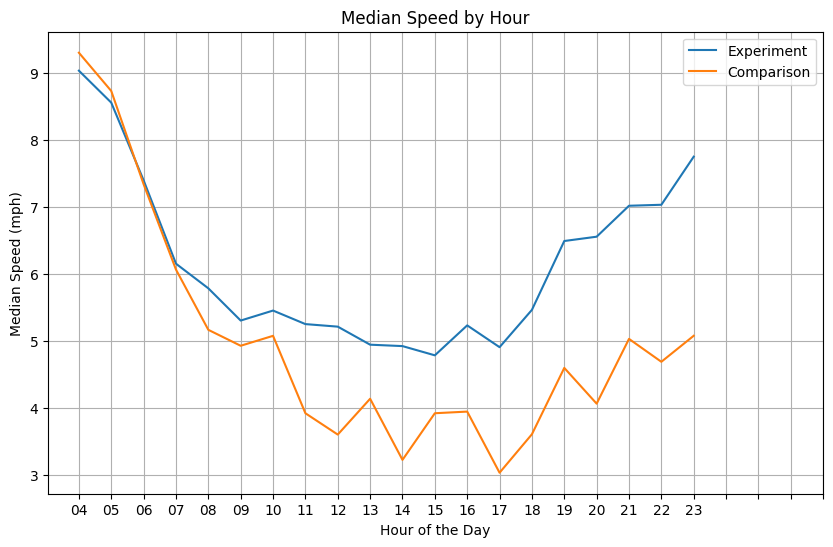

In [34]:
df_experiment = bus_speed_202501thurs_cz.copy()
df_comparison = bus_speed_202412thurs_cz.copy()

# median speed, group by hour and weekday
df_experiment = df_experiment.groupby(["hour", "weekday"]).agg(
    speed_median = ("speed_mph", "median")
).reset_index()

df_comparison = df_comparison.groupby(["hour", "weekday"]).agg(
    speed_median = ("speed_mph", "median")
).reset_index()

# Generate a plot with x-axis as hour of the day and y-axis as median speed (mph)
plt.figure(figsize=(10, 6))
plt.plot(df_experiment["hour"], df_experiment["speed_median"], label="Experiment")
plt.plot(df_comparison["hour"], df_comparison["speed_median"], label="Comparison")
plt.title("Median Speed by Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Median Speed (mph)")
plt.xticks(range(0, 24))
plt.legend()
plt.grid(True)
plt.show()

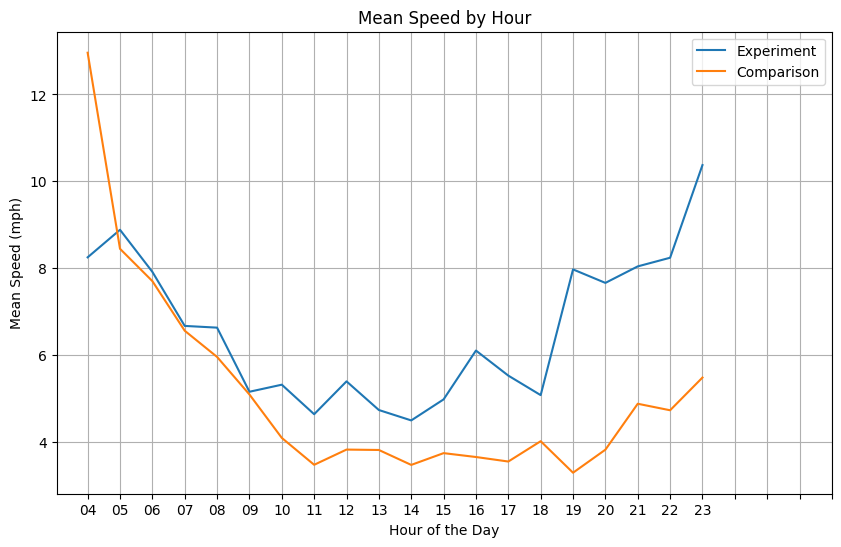

In [35]:
df_experiment = bus_speed_202501thurs_cz.copy()
df_comparison = bus_speed_202412thurs_cz.copy()

# average speed, group by hour and weekday
df_experiment = df_experiment.groupby(["hour", "weekday"]).agg(
    total_segment_length=("segment_length", "sum"),
    total_time_elapsed=("time_elapsed", "sum")
).reset_index()
df_experiment["speed_mean"] = df_experiment["total_segment_length"] / df_experiment["total_time_elapsed"]

df_comparison = df_comparison.groupby(["hour", "weekday"]).agg(
    total_segment_length=("segment_length", "sum"),
    total_time_elapsed=("time_elapsed", "sum")
).reset_index()
df_comparison["speed_mean"] = df_comparison["total_segment_length"] / df_comparison["total_time_elapsed"]

# Generate a plot with x-axis as hour of the day and y-axis as mean speed (mph)
plt.figure(figsize=(10, 6))
plt.plot(df_experiment["hour"], df_experiment["speed_mean"], label="Experiment")
plt.plot(df_comparison["hour"], df_comparison["speed_mean"], label="Comparison")
plt.title("Mean Speed by Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Mean Speed (mph)")
plt.xticks(range(0, 24))
plt.legend()
plt.grid(True)
plt.show()

#### 2. Speed by Segment and Day

Parsed GTFS static feed data successfully, length:  8


/Users/luohy/Documents/Projects/bus-observatory/gtfs-realtime-performance/.venv/lib/python3.10/site-packages/shapely/linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)


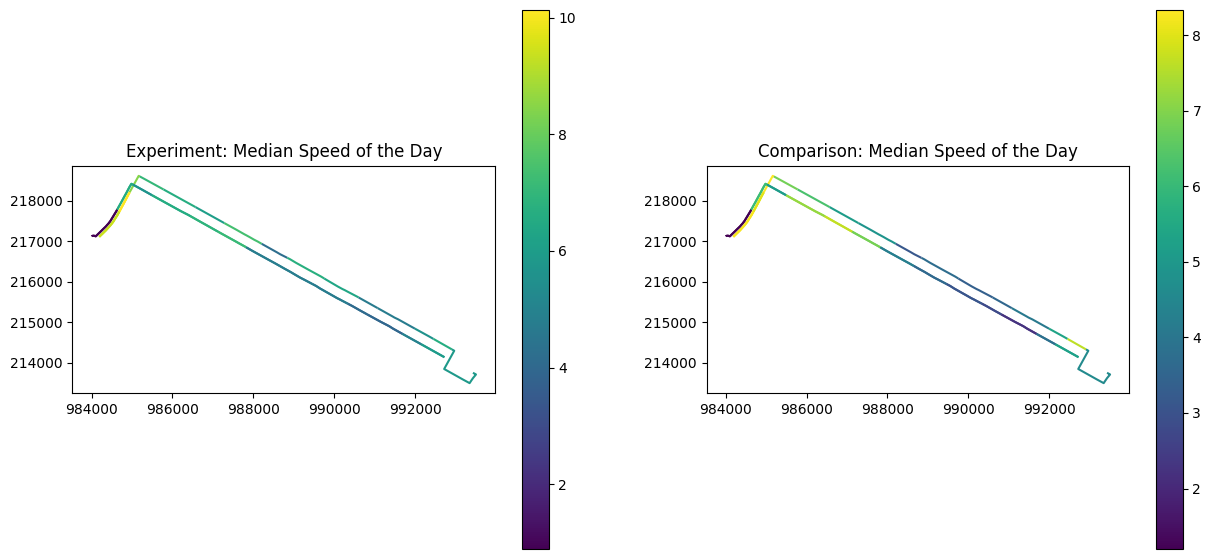

In [41]:
df_experiment = bus_speed_202501thurs_cz.copy()
df_comparison = bus_speed_202412thurs_cz.copy()

# get the segment df first
# TODO: map: date, feed identifier, url, GTFS_dict, shape, segment
# might cause some mismatch as date -> feed -> shape -> segment
url = "https://files.mobilitydatabase.org/mdb-513/mdb-513-202501020055/mdb-513-202501020055.zip"
segment_df = GTFS_shape_processor(url, 4326, 2263).process_shapes()

# median speed for each segment
# merge on (prev_stop_id, stop_id)
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

segment_df.merge(df_experiment.groupby(["prev_stop_id", "stop_id"])["speed_mph"].median().reset_index()).plot(column="speed_mph", legend=True, ax=axes[0])
axes[0].set_title("Experiment: Median Speed of the Day")

segment_df.merge(df_comparison.groupby(["prev_stop_id", "stop_id"])["speed_mph"].median().reset_index()).plot(column="speed_mph", legend=True, ax=axes[1])
axes[1].set_title("Comparison: Median Speed of the Day")

plt.show()


Parsed GTFS static feed data successfully, length:  8


/Users/luohy/Documents/Projects/bus-observatory/gtfs-realtime-performance/.venv/lib/python3.10/site-packages/shapely/linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)


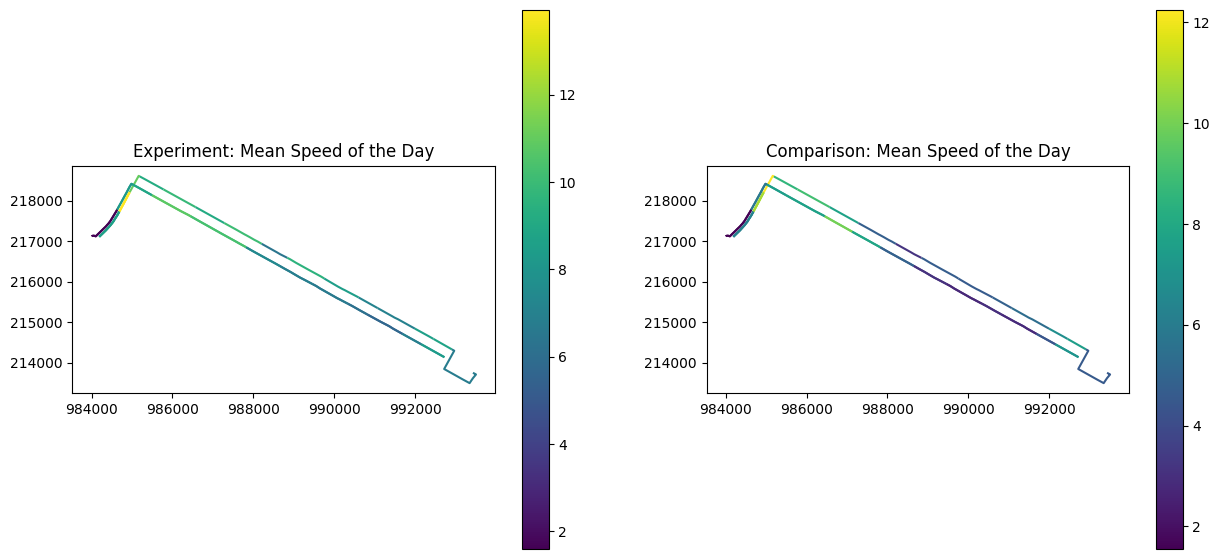

In [42]:
df_experiment = bus_speed_202501thurs_cz.copy()
df_comparison = bus_speed_202412thurs_cz.copy()

# get the segment df first
# TODO: map: date, feed identifier, url, GTFS_dict, shape, segment
# might cause some mismatch as date -> feed -> shape -> segment
url = "https://files.mobilitydatabase.org/mdb-513/mdb-513-202501020055/mdb-513-202501020055.zip"
segment_df = GTFS_shape_processor(url, 4326, 2263).process_shapes()

# mean speed for each segment
# speed_mean = sum(segment_length) / sum(time_elapsed)
df_experiment = df_experiment.groupby(["weekday", "prev_stop_id", "stop_id"]).agg(
    total_segment_length=("segment_length", "sum"),
    total_time_elapsed=("time_elapsed", "sum")
).reset_index()
df_experiment["speed_mean"] = df_experiment["total_segment_length"] / df_experiment["total_time_elapsed"]

df_comparison = df_comparison.groupby(["weekday", "prev_stop_id", "stop_id"]).agg(
    total_segment_length=("segment_length", "sum"),
    total_time_elapsed=("time_elapsed", "sum")
).reset_index()
df_comparison["speed_mean"] = df_comparison["total_segment_length"] / df_comparison["total_time_elapsed"]

# plot
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

segment_df.merge(df_experiment.groupby(["prev_stop_id", "stop_id"])["speed_mean"].median().reset_index()).plot(
    column="speed_mean", legend=True, ax=axes[0]
)
axes[0].set_title("Experiment: Mean Speed of the Day")

segment_df.merge(df_comparison.groupby(["prev_stop_id", "stop_id"])["speed_mean"].median().reset_index()).plot(
    column="speed_mean", legend=True, ax=axes[1]
)
axes[1].set_title("Comparison: Mean Speed of the Day")

plt.show()



#### 3. Speed Change by Distance along a Trip

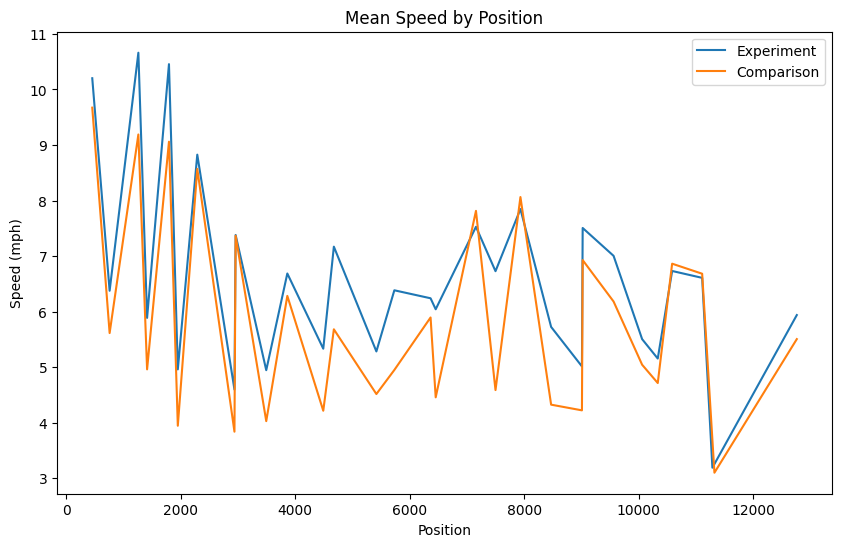

In [53]:
# project_position
# prev_projected_position
# stop_sequence: stop_sequence is a number that indicates the ordering of stops on a trip. It helps distinguish between visits to the same physical stop when a route loops back or passes the same location multiple times
# compute unique combinations of (prev_projected_position, projected_position, stop_sequence)

df_experiment = bus_speed_202501thurs_cz.copy()
df_comparison = bus_speed_202412thurs_cz.copy()

# Treat prev_projected_position and projected_position as 2 positions, and assign them the same speed
# Compute the mean speed for each position

# create a DataFrame with both positions and their corresponding speeds for experiment
positions_speeds_experiment = pd.concat([
    df_experiment[["prev_projected_position", "speed_mph"]].rename(columns={"prev_projected_position": "position"}),
    df_experiment[["projected_position", "speed_mph"]].rename(columns={"projected_position": "position"})
])

# create a DataFrame with both positions and their corresponding speeds for comparison
positions_speeds_comparison = pd.concat([
    df_comparison[["prev_projected_position", "speed_mph"]].rename(columns={"prev_projected_position": "position"}),
    df_comparison[["projected_position", "speed_mph"]].rename(columns={"projected_position": "position"})
])

# compute the mean speed for each position for experiment
mean_speeds_experiment = positions_speeds_experiment.groupby("position")["speed_mph"].mean().reset_index()

# compute the mean speed for each position for comparison
mean_speeds_comparison = positions_speeds_comparison.groupby("position")["speed_mph"].mean().reset_index()

# plot: x - position, y - speed for both experiment and comparison
plt.figure(figsize=(10, 6))
plt.plot(mean_speeds_experiment["position"], mean_speeds_experiment["speed_mph"], label="Experiment")
plt.plot(mean_speeds_comparison["position"], mean_speeds_comparison["speed_mph"], label="Comparison")
plt.title("Mean Speed by Position")
plt.xlabel("Position")
plt.ylabel("Speed (mph)")
plt.legend()
plt.show()


moving on:

- go with the travel time or speed? - speed 
- solve the UTC time difference and the missing time period
- geojson io to get the congestion zone boundary
- geo boundary check with the chosen routes shape
- data pipeline migration
- database design? - design and discuss
- backend service design